In [170]:
# General libraries
import numpy as np 
import pandas as pd

# Pre-Processing
from glob import glob
from PIL import Image
from resizeimage import resizeimage
from sklearn.model_selection import train_test_split

# SVC, PCA, LDA, Metrics
from sklearn.metrics import f1_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-processing

In [262]:
# define path names
man_images = glob('man_200/*')
woman_images = glob('woman_200/*')

In [263]:
# Note: men are False, women are True

man_flattened = []
for path in man_images:
    with open(path, 'r+b') as f:
        with Image.open(f) as image:
            cover = resizeimage.resize_cover(image, [20, 10])
            man_flattened.append((np.array(cover).flatten(), 0))
            
woman_flattened = []
for path in woman_images:
    with open(path, 'r+b') as f:
        with Image.open(f) as image:
            cover = resizeimage.resize_cover(image, [20, 10])
            woman_flattened.append((np.array(cover).flatten(), 1))

In [264]:
man_flattened = np.asarray(man_flattened)
woman_flattened = np.asarray(woman_flattened)
man_flattened.shape, woman_flattened.shape

((200, 2), (200, 2))

In [265]:
X = np.append(man_flattened[:,0], woman_flattened[:,0])
Y = np.append(man_flattened[:,1], woman_flattened[:,1])

X.shape, Y.shape

((400,), (400,))

In [266]:
X = np.stack(i for i in X)
Y = np.stack(i for i in Y)

In [267]:
X.shape, Y.shape

((400, 600), (400,))

In [268]:
# for LDA
X = X.astype('float64')
Y = Y.astype('float64')
X.dtype, Y.dtype

(dtype('float64'), dtype('float64'))

# 1. Simple linear classifier: Support Vector Classification (SVC)

The linear Support Vector Classification (SVC) is a support vector machine implementation with linear kernel. It uses l2 penalization, which is a regularization method that penalizes large changes in coefficients to avoid over-fitting. However, as we can see in the error results of SVC, the test error is 5x as large as the training error, indicating that the model is highly over-fitted to the training data. 

In [269]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.7, random_state=0)
X_train.shape, y_train.shape

((120, 600), (120,))

In [270]:
svc = LinearSVC(random_state=0, tol=1e-5)

In [271]:
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [272]:
svc_tr_err = 1-svc.score(X_train, y_train)
svc_tst_err = 1-svc.score(X_test, y_test)

print('training error: {0:0.3f}'.format(svc_tr_err))
print('test error: {0:0.3f}'.format(svc_tst_err))

training error: 0.000
test error: 0.450


In [273]:
y_pred = svc.predict(X_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.52      0.55      0.53       131
        1.0       0.58      0.55      0.57       149

avg / total       0.55      0.55      0.55       280



# 2. SVC after Principal Component Analysis (PCA)
The Principal Component Analysis (PCA) is an unsupervised dimensional reduction method that maximizes the variance of projected data points on the best fitted line. (Which is equal to minimizing the sum of the squares between the data and the line --> minimizing the error.) The more components, the more variance can be explained in a data set. To match the dimensions for LDA (forced to use number of classes - 1 = 1 dimension), the following dimension reduction reduces the initial 6000 dimensions down to 1, explaining 35% of the variance.

### transforming/ reducing the data via SVC

In [306]:
# use the entire data set, not only train/ test, to transform the data
pca_1 = PCA(n_components=1)
X_pca_1 = pca_1.fit(X).transform(X)

print('explained variance ratio : %s'
      % str(pca_1.explained_variance_ratio_))

explained variance ratio : [0.36370177]


In [275]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_1, Y, test_size=0.7, random_state=0)
X_train.shape, y_train.shape

((120, 1), (120,))

### train an SVC model on the reduced data

In [276]:
svc = LinearSVC(random_state=0, tol=1e-5)
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [277]:
pca_tr_err = 1-svc.score(X_train, y_train)
pca_tst_err = 1-svc.score(X_test, y_test)

print('training error: {0:0.3f}'.format(pca_tr_err))
print('test error: {0:0.3f}'.format(pca_tst_err))

training error: 0.442
test error: 0.464


In [278]:
y_pred = svc.predict(X_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.69      0.52      0.60       183
        1.0       0.38      0.56      0.45        97

avg / total       0.58      0.54      0.55       280



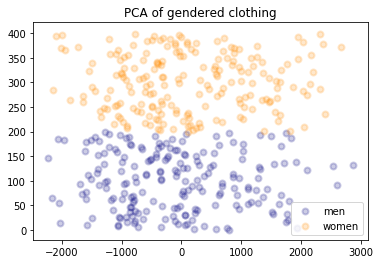

In [291]:
colors = ['navy', 'darkorange']
target_names = ['men', 'women']

for color, i, target_name in zip(colors, [0, 1], target_names):
    y_0 = [0 for x in range(len(X_pca_1[Y == i]))]
    test = X_pca_1.tolist()
    test_values = X_pca_1[Y == i]
    y_0 = [test.index(i) for i in test_values]
    plt.scatter(X_pca_1[Y == i], 
                y_0, 
                color=color, alpha=.2, lw=2, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of gendered clothing')
plt.show()

# 3. SVC after Linear Discriminant Analysis (LDA)
Linear Discriminant Analysis (LDA) is a supervised dimensionality reduction method that maximizes the variance of data points projected on a linear discriminant between different classes and minimizes the variance within one class. Since LDA is limited to number of classes - 1 components, and we have 2 classes (men, women), the number of components is 1. 

The original implementation (svd solver) caused collinearity errors, thus I had to use an eigenvalue decomposition solver combined with a shrinkage parameter to avoid the collinearity issue. Because my computer couldn't deal with 60,000 dimensions, I reduced it to 600, which affects the performance but shows that technically this approach would work if my computer had higher processing power.

### transforming/ reducing the data via LDA

In [281]:
lda = LDA(solver='eigen', shrinkage='auto')

In [282]:
# lda = LDA(n_components=1)
lda.fit(X, Y)
X_lda = lda.fit(X, Y).transform(X)

In [283]:
print('explained variance ratio (first component): %s'
      % str(lda.explained_variance_ratio_))

explained variance ratio (first component): [0.0026374]


In [284]:
X_train, X_test, y_train, y_test = train_test_split(
    X_lda, Y, test_size=0.7, random_state=0)
X_train.shape, y_train.shape

((120, 1), (120,))

### train an SVC model on the reduced data

In [285]:
svc = LinearSVC(random_state=0, tol=1e-5)
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [286]:
lda_tr_err = 1-svc.score(X_train, y_train)
lda_tst_err = 1-svc.score(X_test, y_test)

print('training error: {0:0.3f}'.format(lda_tr_err))
print('test error: {0:0.3f}'.format(lda_tst_err))

training error: 0.083
test error: 0.082


In [287]:
y_pred = svc.predict(X_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.93      0.91      0.92       142
        1.0       0.91      0.93      0.92       138

avg / total       0.92      0.92      0.92       280



# Conclusion
I would choose the PCA reduced SVC model to classify the data. SVC with the original data has a huge error increase for the test data, indicating that the model is highly over-fitted. The LDA reduction is limited by being able to reduce to one dimension only, and has unbelievably low error-values, which is why I disregard its results believing that the model or implementation is incorrect. Using 28 dimensions instead of 1, the model in the appendix was able to bring down the test error rate to 0.429, furthermore encouraging the use thereof. 

In [288]:
results = {
    'original SVC':[svc_tr_err, svc_tst_err],
    'PCA - SVC':[pca_tr_err, pca_tst_err],
    'LDA - SVC':[lda_tr_err, lda_tst_err]
}
pd.DataFrame(results, index=['training error', 'test error']).round(2)

,original SVC,PCA - SVC,LDA - SVC
training error,0.00,0.44,0.08
test error,0.45,0.46,0.08


# Appendix

# PCA with 2 components
## Rarely any improvement

In [293]:
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit(X).transform(X)

print('explained variance ratio (first two components): %s'
      % str(pca_2.explained_variance_ratio_))

explained variance ratio (first two components): [0.36370177 0.15941542]


In [294]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_2, Y, test_size=0.7, random_state=0)
X_train.shape, y_train.shape

((120, 2), (120,))

In [295]:
svc = LinearSVC(random_state=0, tol=1e-5)
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [296]:
pca2_tr_err = 1-svc.score(X_train, y_train)
pca2_tst_err = 1-svc.score(X_test, y_test)

print('training error: {0:0.3f}'.format(pca2_tr_err))
print('test error: {0:0.3f}'.format(pca2_tst_err))

training error: 0.575
test error: 0.582


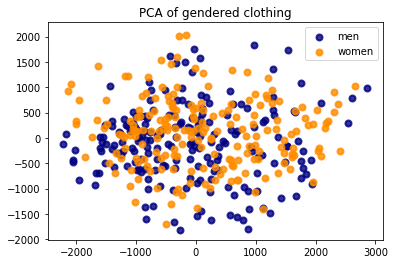

In [297]:
colors = ['navy', 'darkorange']
target_names = ['men', 'women']

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca_2[Y == i, 0], X_pca_2[Y == i, 1], 
                color=color, alpha=.8, lw=2, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of gendered clothing')
plt.show()

# 28 components for 90% variance explained

In [298]:
pca_50 = PCA(n_components=50)

In [299]:
X_pca_50 = pca_50.fit(X).transform(X)

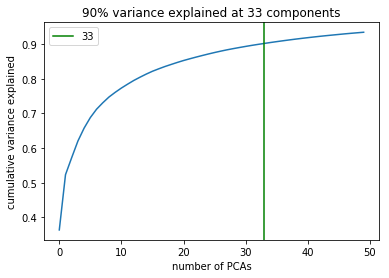

In [300]:
variance_explained = pca_50.explained_variance_ratio_
cum_var_explained = np.cumsum(variance_explained)

# https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
x = next(x[0] for x in enumerate(cum_var_explained) if x[1] > 0.9)

plt.plot(cum_var_explained)
plt.axvline(x=x, color='g', label=x)
plt.ylabel('cumulative variance explained')
plt.xlabel('number of PCAs')
plt.title('90% variance explained at {0:0.0f} components'.format(x))
plt.legend()
plt.show()

In [301]:
pca_28 = PCA(n_components=28)
X_pca_28 = pca_28.fit(X).transform(X)

print('explained variance ratio (first two components): %s'
      % str(pca_2.explained_variance_ratio_))

X_train, X_test, y_train, y_test = train_test_split(
    X_pca_28, Y, test_size=0.7, random_state=0)

svc = LinearSVC(random_state=0, tol=1e-5)
svc.fit(X_train, y_train)

pca28_tr_err = 1-svc.score(X_train, y_train)
pca28_tst_err = 1-svc.score(X_test, y_test)

print('training error: {0:0.3f}'.format(pca28_tr_err))
print('test error: {0:0.3f}'.format(pca28_tst_err))

explained variance ratio (first two components): [0.36370177 0.15941542]
training error: 0.358
test error: 0.429


In [302]:
y_pred = svc.predict(X_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.59      0.57      0.58       145
        1.0       0.55      0.58      0.57       135

avg / total       0.57      0.57      0.57       280

